# Data Analysis of the Swedish Restaurants that sell pizza

In [41]:
import pandas as pd
import seaborn as sns
import numpy as np
import geocoder
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt

In [42]:
df = pd.read_json('restaurant_data_webscrapping.json',dtype={"num_employees": "Int32",
                                                 'last_year_revenue':"Int32",
                                                 'last_year_result_after_financial_assets':"Int32"})
df.head(5)

,name,type,city,url,address,email,num_employees,telephone,last_year_revenue,last_year_result_after_financial_assets,cash_flow_word,cash_flow_percent,profit_margin_word,profit_margin_percent,solidity_word,solidity_percent
0,Aneby Grill & Pizzeria,Pizzeria,Aneby,None,"Storgatan 51, 57832 Aneby",None,6,0380-418 19,7026,679,Very Good,484.1,Satisfactory,9.7,Very Good,74.2
1,Restaurang Estelle,Restaurant,Stenstorp,http://www.restaurangestelle.se/,"Storgatan 21, 52160 Stenstorp",None,4,0500-45 80 23,4709,96,Not Satisfactory,23.9,Weak,2.4,Good,32.3
2,Le Ski Lodge,Restaurant,Storlien,http://www.leski.se,"Storlien , 83799 Storlien",info@leski.se,0,0647-701 51,231,414,Satisfactory,131.7,Very Good,184.4,Good,31.5
3,Pizzeria Pinan,Restaurant,Hönö,http://www.pinanpizzeria.se,"Göteborgsvägen 3, 47540 Hönö",None,<NA>,031-97 00 27,<NA>,<NA>,None,NaN,None,NaN,None,NaN
4,Valje Strandkrog Ab,Restaurant,Sölvesborg,None,"Sölvesborgsvägen 4, 29477 Sölvesborg",None,5,073-180 27 05,3568,275,Very Good,200.4,Satisfactory,7.7,Very Good,54.7


Generate latitude and addresses of restaurants and cities if they do not exist

In [43]:
# To use Bing as provider (Requires an API Key)
#https://geocoder.readthedocs.io/providers/Bing.html
# load_dotenv()
# BING_API_KEY = os.getenv('BING_API_KEY')
# g = geocoder.bing('Storlien, Sweden', key=BING_API_KEY)
# g.json
# MAPBOX_API_KEY = os.getenv('MAPBOX_API_KEY')
# g = geocoder.mapbox('Storlien, Sweden', key=MAPBOX_API_KEY)
# g.json

In [44]:
def geocode_address_arcgis(address):
    """Function that uses geocoder library to get the latitude and longitude of an address"""
    result = geocoder.arcgis(location=address)
    if result.ok:
        lat, lon = result.latlng
        return {"address_latitude": lat, "address_longitude": lon}
    else:
        raise Exception("I have gotten a bad result :-(")

In [45]:
if 'address_latitude' not in list(df.columns) and 'address_longitude' not in list(df.columns):
    try:
        df = pd.read_json('restaurant_data_processed.json',  orient='split', dtype={"num_employees": "Int32",
                                                 'last_year_revenue':"Int32",
                                                 'last_year_result_after_financial_assets':"Int32",
                                                 'population':"Int32"}) 
    except:
        # Create the 'address_latitude' and 'address_longitude' columns with the geocode function and save to json
        df[['address_latitude', 'address_longitude']] = df.apply(lambda row: geocode_address_arcgis(row['address']), axis='columns', result_type='expand')
        df.to_json('restaurant_data_processed.json', index=False, orient='split')

        # Get the list of cities with the country
        city_country = df['city'].apply(lambda x: x + ', Sweden')
        df_city_country = pd.DataFrame(city_country.unique(), columns=['city_country']) # Get unique cities

        # Get the longitude and latitude of each city
        df_city_country[['city_latitude', 'city_longitude']] = df_city_country.apply(lambda row: geocode_address_arcgis(row['city_country']), axis='columns', result_type='expand')

        df_city_country['city_country'] = df_city_country['city_country'].apply(lambda x: x.replace(', Sweden','')) # Quit the country
        df_city_country.columns = ['city','city_latitude','city_longitude'] # Rename the city column

        df = df.merge(df_city_country, how='left', on='city') # Merge the result with the original df
        df.to_json('restaurant_data_processed.json', index=False, orient='split') # Save this last json

        # Get the 2022 population of the cities
        url_sweden_population = 'https://www.scb.se/en/finding-statistics/statistics-by-subject-area/population/population-composition/population-statistics/pong/tables-and-graphs/population-statistics---year/population-in-the-country-counties-and-municipalities-on-31-december-2022-and-population-change-in-2022/'
        dfs = pd.read_html(url_sweden_population, flavor='lxml')
        df_sw_population = dfs[0]
        df_sw_population = df_sw_population.iloc[:,1:3].droplevel(0, axis=1).droplevel(0, axis=1) # Select only the city and total population columns, and reduce the multi index columns
        df_sw_population.columns = ['city', 'population']
        df_sw_population['population'] = df_sw_population.apply(lambda row: row['population'].replace("\xa0", ""), axis='columns')
        df_sw_population['population'].astype('Int32')
        df = df.merge(df_sw_population, how='left', on='city') # Merge the result with the original df
        df.to_json('restaurant_data_processed.json', index=False, orient='split') # Save this last json

In [46]:
df

,name,type,city,url,address,email,num_employees,telephone,last_year_revenue,last_year_result_after_financial_assets,...,cash_flow_percent,profit_margin_word,profit_margin_percent,solidity_word,solidity_percent,address_latitude,address_longitude,city_latitude,city_longitude,population
0,Aneby Grill & Pizzeria,Pizzeria,Aneby,0,"Storgatan 51, 57832 Aneby",0,6,1,7026,679,...,484.1,Satisfactory,9.7,Very Good,74.2,57.839266,14.817377,57.83955,14.81813,6824
1,Restaurang Estelle,Restaurant,Stenstorp,1,"Storgatan 21, 52160 Stenstorp",0,4,1,4709,96,...,23.9,Weak,2.4,Good,32.3,58.272077,13.712535,58.27271,13.71599,<NA>
2,Le Ski Lodge,Restaurant,Storlien,1,"Storlien , 83799 Storlien",1,0,1,231,414,...,131.7,Very Good,184.4,Good,31.5,63.317140,12.097400,63.31558,12.10339,<NA>
3,Pizzeria Pinan,Restaurant,Hönö,1,"Göteborgsvägen 3, 47540 Hönö",0,<NA>,1,<NA>,<NA>,...,NaN,None,NaN,None,NaN,57.698614,11.665229,57.68268,11.64547,<NA>
4,Valje Strandkrog Ab,Restaurant,Sölvesborg,0,"Sölvesborgsvägen 4, 29477 Sölvesborg",0,5,1,3568,275,...,200.4,Satisfactory,7.7,Very Good,54.7,56.063119,14.540006,56.05295,14.58356,17514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923,Melkers Restaurang & Pizzeria,Pizzeria,Holmsjö,1,"Holmsjövägen 87, 37337 Holmsjö",0,<NA>,1,<NA>,<NA>,...,NaN,None,NaN,None,NaN,56.422465,15.539309,56.42329,15.53884,<NA>
1924,Uncle Joe'S,Restaurant,Visby,1,"Langs väg 2, 62150 Visby",1,19,1,20931,586,...,115.9,Weak,2.8,Good,39.6,57.615535,18.283874,57.63844,18.30004,<NA>
1925,Gamlegårdens Grekiska Restaurang,Restaurant,Kristianstad,1,"Näsbychaussén 70, 29136 Kristianstad",0,4,1,3200,33,...,105.5,Weak,1.0,Good,31.5,56.055260,14.159496,56.03099,14.15416,86738
1926,Stopet Hotell & Värdshus,Other,Grängesberg,1,"Kopparbergsvägen 60, 77230 Grängesberg",0,8,1,8131,562,...,64.7,Satisfactory,7.5,Very Good,47.3,60.076384,15.007630,60.07598,15.00664,<NA>


In [47]:
df.head()

,name,type,city,url,address,email,num_employees,telephone,last_year_revenue,last_year_result_after_financial_assets,...,cash_flow_percent,profit_margin_word,profit_margin_percent,solidity_word,solidity_percent,address_latitude,address_longitude,city_latitude,city_longitude,population
0,Aneby Grill & Pizzeria,Pizzeria,Aneby,0,"Storgatan 51, 57832 Aneby",0,6,1,7026,679,...,484.1,Satisfactory,9.7,Very Good,74.2,57.839266,14.817377,57.83955,14.81813,6824
1,Restaurang Estelle,Restaurant,Stenstorp,1,"Storgatan 21, 52160 Stenstorp",0,4,1,4709,96,...,23.9,Weak,2.4,Good,32.3,58.272077,13.712535,58.27271,13.71599,<NA>
2,Le Ski Lodge,Restaurant,Storlien,1,"Storlien , 83799 Storlien",1,0,1,231,414,...,131.7,Very Good,184.4,Good,31.5,63.317140,12.097400,63.31558,12.10339,<NA>
3,Pizzeria Pinan,Restaurant,Hönö,1,"Göteborgsvägen 3, 47540 Hönö",0,<NA>,1,<NA>,<NA>,...,NaN,None,NaN,None,NaN,57.698614,11.665229,57.68268,11.64547,<NA>
4,Valje Strandkrog Ab,Restaurant,Sölvesborg,0,"Sölvesborgsvägen 4, 29477 Sölvesborg",0,5,1,3568,275,...,200.4,Satisfactory,7.7,Very Good,54.7,56.063119,14.540006,56.05295,14.58356,17514


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1928 entries, 0 to 1927
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   name                                     1928 non-null   object 
 1   type                                     1928 non-null   object 
 2   city                                     1928 non-null   object 
 3   url                                      1928 non-null   int64  
 4   address                                  1928 non-null   object 
 5   email                                    1928 non-null   int64  
 6   num_employees                            1146 non-null   Int32  
 7   telephone                                1928 non-null   int64  
 8   last_year_revenue                        1146 non-null   Int32  
 9   last_year_result_after_financial_assets  1146 non-null   Int32  
 10  cash_flow_word                           1112 no

In [49]:
df.describe()

,url,email,num_employees,telephone,last_year_revenue,last_year_result_after_financial_assets,cash_flow_percent,profit_margin_percent,solidity_percent,address_latitude,address_longitude,city_latitude,city_longitude,population
count,1928.000000,1928.000000,1146.0,1928.000000,1146.0,1146.0,1112.000000,1065.000000,1142.000000,1928.000000,1928.000000,1928.000000,1928.000000,1358.0
mean,0.372925,0.084544,12.776614,0.842842,20604.363874,665.376091,214.148112,5.185915,37.921541,58.626118,15.175480,58.720488,15.390043,188508.058174
std,0.483708,0.278273,227.347651,0.364044,358568.420419,6642.615466,192.963473,36.783408,77.792976,2.481858,5.985616,2.054855,2.480666,274765.634114
min,0.000000,0.000000,0.0,0.000000,0.0,-31125.0,-176.500000,-487.500000,-811.500000,19.467724,-155.165307,55.360950,11.031130,2413.0
25%,0.000000,0.000000,2.0,1.000000,2140.5,-8.0,85.700000,0.200000,23.025000,57.631787,13.027766,57.650600,13.001100,28103.0
50%,0.000000,0.000000,4.0,1.000000,4077.5,150.5,148.500000,5.100000,47.950000,58.913703,15.279749,58.942645,15.280260,85450.0
75%,1.000000,0.000000,6.0,1.000000,6674.5,530.75,283.975000,11.600000,70.000000,59.396862,17.834480,59.404200,17.814380,158057.0
max,1.000000,1.000000,7619.0,1.000000,10982678.0,204734.0,996.300000,539.800000,531.600000,67.849907,32.657720,67.855520,24.137430,984748.0


## Correct the data

In [50]:
type_restaurant = df["type"].value_counts()
type_restaurant

type
Restaurant    1143
Pizzeria       685
Other          100
Name: count, dtype: int64

In [51]:
# Reduce the value of types to Restaurant, Pizzeria and Other
def correct_types(type_restaurant):
    if type_restaurant == 'Restaurang' or 'restaurang' in type_restaurant.lower() or 'restaurant' in type_restaurant.lower():
        return 'Restaurant'
    elif 'pizza' in type_restaurant.lower() or 'pizzeria' in type_restaurant.lower():
        return 'Pizzeria'
    else:
        return 'Other'

df['type'] = df['type'].apply(correct_types)

In [52]:
df["type"].value_counts()

type
Restaurant    1143
Pizzeria       685
Other          100
Name: count, dtype: int64

In [53]:
# Transform the url, email, telephone to categorical variables
df['email'].fillna(0, inplace=True)
df['url'].fillna(0, inplace=True)
df['telephone'].fillna(0, inplace=True)

def transform_to_one(info):
    if info != 0:
        return 1
    else:
        return info
df['email'] = df['email'].apply(transform_to_one).astype("category")
df['url'] = df['url'].apply(transform_to_one).astype("category")
df['telephone'] = df['telephone'].apply(transform_to_one).astype("category")
df['type'] = df['type'].astype("category") # Also transformed to category dtype
df['cash_flow_word'] = df['cash_flow_word'].astype("category") # Also transformed to category dtype
df['profit_margin_word'] = df['profit_margin_word'].astype("category") # Also transformed to category dtype
df['solidity_word'] = df['solidity_word'].astype("category") # Also transformed to category dtype
df.head()

,name,type,city,url,address,email,num_employees,telephone,last_year_revenue,last_year_result_after_financial_assets,...,cash_flow_percent,profit_margin_word,profit_margin_percent,solidity_word,solidity_percent,address_latitude,address_longitude,city_latitude,city_longitude,population
0,Aneby Grill & Pizzeria,Pizzeria,Aneby,0,"Storgatan 51, 57832 Aneby",0,6,1,7026,679,...,484.1,Satisfactory,9.7,Very Good,74.2,57.839266,14.817377,57.83955,14.81813,6824
1,Restaurang Estelle,Restaurant,Stenstorp,1,"Storgatan 21, 52160 Stenstorp",0,4,1,4709,96,...,23.9,Weak,2.4,Good,32.3,58.272077,13.712535,58.27271,13.71599,<NA>
2,Le Ski Lodge,Restaurant,Storlien,1,"Storlien , 83799 Storlien",1,0,1,231,414,...,131.7,Very Good,184.4,Good,31.5,63.317140,12.097400,63.31558,12.10339,<NA>
3,Pizzeria Pinan,Restaurant,Hönö,1,"Göteborgsvägen 3, 47540 Hönö",0,<NA>,1,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,57.698614,11.665229,57.68268,11.64547,<NA>
4,Valje Strandkrog Ab,Restaurant,Sölvesborg,0,"Sölvesborgsvägen 4, 29477 Sölvesborg",0,5,1,3568,275,...,200.4,Satisfactory,7.7,Very Good,54.7,56.063119,14.540006,56.05295,14.58356,17514


In [54]:
df_clean = df.dropna(axis=0)
df_clean.head()

,name,type,city,url,address,email,num_employees,telephone,last_year_revenue,last_year_result_after_financial_assets,...,cash_flow_percent,profit_margin_word,profit_margin_percent,solidity_word,solidity_percent,address_latitude,address_longitude,city_latitude,city_longitude,population
0,Aneby Grill & Pizzeria,Pizzeria,Aneby,0,"Storgatan 51, 57832 Aneby",0,6,1,7026,679,...,484.1,Satisfactory,9.7,Very Good,74.2,57.839266,14.817377,57.83955,14.81813,6824
4,Valje Strandkrog Ab,Restaurant,Sölvesborg,0,"Sölvesborgsvägen 4, 29477 Sölvesborg",0,5,1,3568,275,...,200.4,Satisfactory,7.7,Very Good,54.7,56.063119,14.540006,56.05295,14.58356,17514
6,Pizzeria I Strömstad,Restaurant,Strömstad,1,"Korpegatan 32, 45231 Strömstad",0,5,1,8352,2227,...,708.0,Very Good,26.9,Very Good,61.8,58.935774,11.180260,58.93870,11.17124,13290
7,Torstens Smakar Mera,Restaurant,Båstad,1,"Köpmansgatan 70B, 26931 Båstad",1,5,1,5609,-26,...,246.3,Not Satisfactory,-0.5,Very Good,67.4,56.427229,12.847600,56.42869,12.84472,15824
8,Pizzeria Babylon,Pizzeria,Nora,1,"Kungsgatan 6, 71331 Nora",0,5,1,6745,96,...,156.0,Weak,1.4,Very Good,52.4,59.518709,15.041311,59.51925,15.03905,10701


## Analysis

Use the Box plot to check for outliers

c:\Users\rodri\.virtualenvs\webscrapping-7cJ6Jy-h\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\rodri\.virtualenvs\webscrapping-7cJ6Jy-h\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\rodri\.virtualenvs\webscrapping-7cJ6Jy-h\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


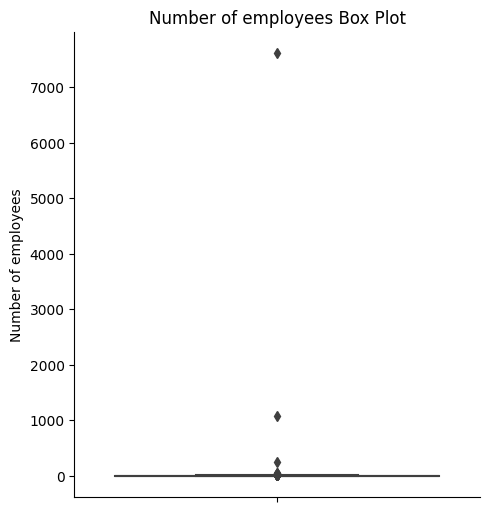

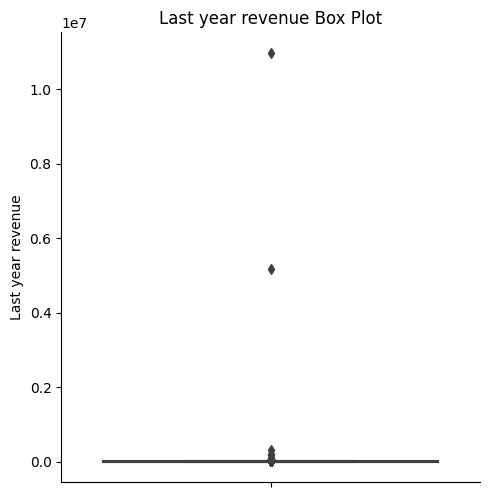

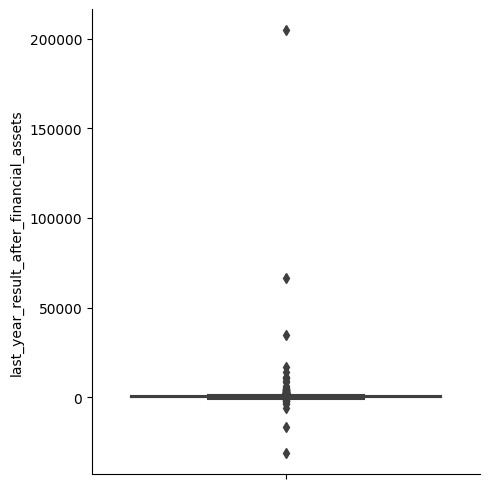

In [55]:

g = sns.catplot(data=df_clean, y='num_employees', kind='box')
g.set(ylabel='Number of employees', title='Number of employees Box Plot')
g = sns.catplot(data=df_clean, y='last_year_revenue', kind='box')
g.set(ylabel='Last year revenue', title='Last year revenue Box Plot')
g = sns.catplot(data=df_clean, y='last_year_result_after_financial_assets', kind='box')
g.set(ylabel='Last year result after financial assets', title='Last year result after financial assets Box Plot')

In [17]:
# There are outliers in the num_employees. I will not consider restaurants with above 13 employees
df_clean = df_clean[df_clean['num_employees']<13]

c:\Users\rodri\.virtualenvs\webscrapping-7cJ6Jy-h\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


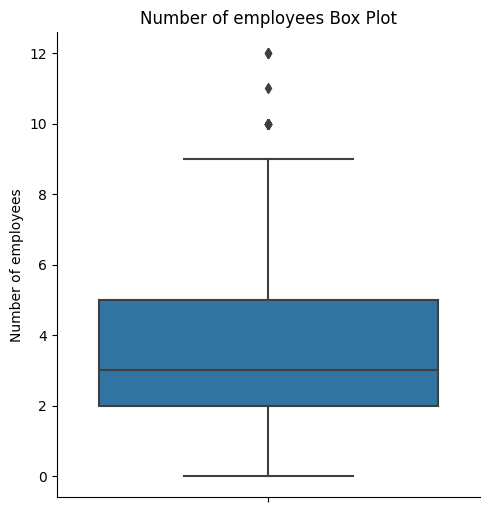

In [39]:
g = sns.catplot(data=df_clean, y='num_employees', kind='box')
g.set(ylabel='Number of employees', title='Number of employees Box Plot')

In [19]:
# There are outliers in the last_year_revenue. I will not consider restaurants with 'last_year_revenue' < 11000
df_clean = df_clean[df_clean['last_year_revenue']<11000]

c:\Users\rodri\.virtualenvs\webscrapping-7cJ6Jy-h\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


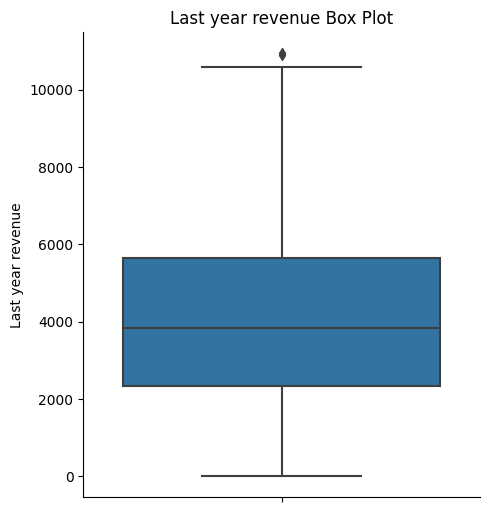

In [38]:
g = sns.catplot(data=df_clean, y='last_year_revenue', kind='box')
g.set(ylabel='Last year revenue', title='Last year revenue Box Plot')

In [21]:
df_clean.describe()

,num_employees,last_year_revenue,last_year_result_after_financial_assets,cash_flow_percent,profit_margin_percent,solidity_percent,address_latitude,address_longitude,city_latitude,city_longitude,population
count,675.0,675.0,675.0,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.0
mean,3.942222,4329.361481,251.354074,220.066667,4.281481,34.487852,58.831686,15.417110,58.835314,15.426444,162585.42963
std,2.473823,2582.924937,590.361209,193.708673,44.154776,82.817833,2.293832,2.517038,2.294106,2.518232,247367.336207
min,0.0,3.0,-2991.0,2.000000,-487.500000,-752.000000,55.372016,11.124206,55.375610,11.171240,2667.0
25%,2.0,2376.5,-14.5,87.550000,-0.150000,21.000000,57.411581,13.157694,57.414145,13.158430,26778.0
50%,3.0,3999.0,138.0,157.600000,4.800000,48.300000,58.937155,15.207311,58.938700,15.217590,76237.0
75%,5.0,6096.5,422.5,291.150000,10.650000,68.950000,59.450057,17.628414,59.436850,17.624000,150975.0
max,12.0,10955.0,3864.0,965.500000,539.800000,243.600000,67.849907,24.137523,67.855520,24.137430,984748.0


In [22]:
# There are outliers in the last_year_result_after_financial_assets. I will consider restaurants with 'last_year_result_after_financial_assets' < 11000 and > - 1000
df_clean = df_clean[(df_clean['last_year_result_after_financial_assets']<1100) & (df_clean['last_year_result_after_financial_assets']>(-1000))]

c:\Users\rodri\.virtualenvs\webscrapping-7cJ6Jy-h\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


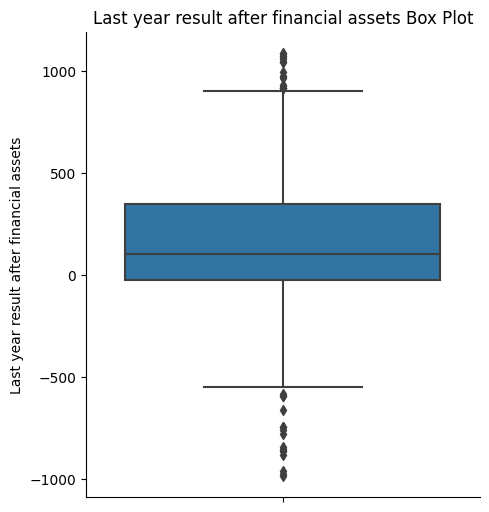

In [37]:
g = sns.catplot(data=df_clean, y='last_year_result_after_financial_assets', kind='box')
g.set(ylabel='Last year result after financial assets', title='Last year result after financial assets Box Plot')

c:\Users\rodri\.virtualenvs\webscrapping-7cJ6Jy-h\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


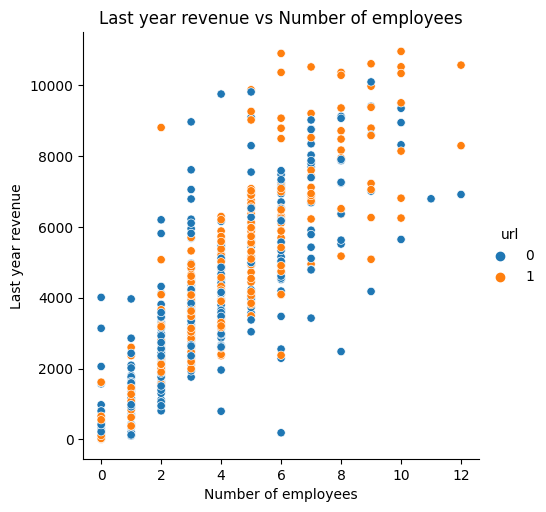

In [36]:
# Relation of number of employees with revenue
g = sns.relplot(data=df_clean, x="num_employees", y="last_year_revenue", hue="url")
g.set(xlabel='Number of employees', ylabel='Last year revenue', title='Last year revenue vs Number of employees')

In [99]:
columns_numeric_city = ['city', 'num_employees', 'last_year_revenue', 'last_year_result_after_financial_assets',
    'cash_flow_percent', 'profit_margin_percent','solidity_percent', 'address_latitude', 'address_longitude',
     'city_latitude', 'city_longitude', 'population']

df_numeric_city = df_clean[columns_numeric_city]

In [100]:
df_grouped_by_city = df_numeric_city.groupby(by='city').mean()
df_grouped_by_city

,num_employees,last_year_revenue,last_year_result_after_financial_assets,cash_flow_percent,profit_margin_percent,solidity_percent,address_latitude,address_longitude,city_latitude,city_longitude,population
city,,,,,,,,,,,
Alingsås,3.0,3732.0,340.0,314.80000,9.5000,77.25000,57.929268,12.514903,57.92963,12.53240,42199.0
Alvesta,7.0,6191.5,237.5,122.55000,4.2000,9.15000,56.899172,14.554301,56.90211,14.55861,20257.0
Aneby,6.0,7026.0,679.0,484.10000,9.7000,74.20000,57.839266,14.817377,57.83955,14.81813,6824.0
Arboga,1.5,1638.0,-61.5,344.90000,-2.4500,16.75000,59.395652,15.850700,59.39615,15.84135,14083.0
Arjeplog,4.0,3383.0,-37.0,199.80000,-1.1000,57.80000,66.051349,17.889644,66.05213,17.89029,2667.0
...,...,...,...,...,...,...,...,...,...,...,...
Åstorp,3.0,4965.0,551.0,144.80000,11.8000,53.90000,56.134903,12.944728,56.13451,12.94657,16341.0
Åtvidaberg,3.0,3874.0,701.0,250.30000,18.2000,59.10000,58.199692,16.001124,58.20058,16.00084,11506.0
Örebro,4.125,4175.125,-62.875,226.43125,-0.3125,0.90625,59.268994,15.213347,59.27084,15.21759,158057.0


In [101]:
df_grouped_by_city.reset_index(inplace=True)

In [102]:
df_grouped_by_city.head()

,city,num_employees,last_year_revenue,last_year_result_after_financial_assets,cash_flow_percent,profit_margin_percent,solidity_percent,address_latitude,address_longitude,city_latitude,city_longitude,population
0,Alingsås,3.0,3732.0,340.0,314.80,9.50,77.25,57.929268,12.514903,57.92963,12.53240,42199.0
1,Alvesta,7.0,6191.5,237.5,122.55,4.20,9.15,56.899172,14.554301,56.90211,14.55861,20257.0
2,Aneby,6.0,7026.0,679.0,484.10,9.70,74.20,57.839266,14.817377,57.83955,14.81813,6824.0
3,Arboga,1.5,1638.0,-61.5,344.90,-2.45,16.75,59.395652,15.850700,59.39615,15.84135,14083.0
4,Arjeplog,4.0,3383.0,-37.0,199.80,-1.10,57.80,66.051349,17.889644,66.05213,17.89029,2667.0


In [148]:
import plotly.express as px

fig = px.scatter_mapbox(df_grouped_by_city, 
                        lon=df_grouped_by_city['city_longitude'],
                        lat=df_grouped_by_city['city_latitude'],
                        zoom=3,
                        color=df_grouped_by_city['last_year_revenue'],
                        size=list(df_grouped_by_city['num_employees']),
                        width=1100,
                        height=600,
                        title='Average Revenue by city. Size is the avg number of employees',
                        custom_data = ['city','population', 'num_employees', 'last_year_revenue', 'last_year_result_after_financial_assets'],
                        )
# hover_name='city',
#                         hover_data=['population']
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={'r':0,'t':50,'l':0,'b':10})
fig.update_traces(hovertemplate="""<b>City: %{customdata[0]}</b><br>Population: %{customdata[1]}<br>Avg Employees: %{customdata[2]:.1f}<br>Last Year Avg Revenue: %{customdata[3]:.1f}<br>Last Year Avg Result After Financial Assets: %{customdata[4]:.1f}""")
fig.show() 

In [106]:
# Top cities with max last_year_revenue
df_grouped_by_city.sort_values(by='last_year_revenue', ascending=False).head()

,city,num_employees,last_year_revenue,last_year_result_after_financial_assets,cash_flow_percent,profit_margin_percent,solidity_percent,address_latitude,address_longitude,city_latitude,city_longitude,population
153,Vara,5.0,9863.0,971.0,87.40,12.80,27.60,58.261692,12.953938,58.26266,12.95348,16163.0
72,Laxå,4.0,9742.0,425.0,187.90,15.20,20.00,58.981527,14.624649,58.98735,14.62067,5576.0
34,Habo,7.5,9027.0,287.5,93.50,3.90,25.55,57.907367,14.075373,59.56954,17.52867,13128.0
19,Ekerö,5.0,9011.0,22.0,60.10,0.20,10.60,59.274771,17.785241,59.29117,17.80709,29123.0
169,Åre,9.0,8882.5,549.5,99.55,6.75,65.00,63.377464,13.156519,63.39964,13.07865,12330.0


In [145]:
fig = px.scatter_mapbox(df_grouped_by_city, 
                        lon=df_grouped_by_city['city_longitude'],
                        lat=df_grouped_by_city['city_latitude'],
                        zoom=3,
                        color=df_grouped_by_city['last_year_result_after_financial_assets'],
                        size=list(df_grouped_by_city['num_employees']),
                        width=1100,
                        height=600,
                        title='Last Year Avg Result After Financial Assets by city. Size is the avg number of employees',
                        custom_data = ['city','population', 'num_employees', 'last_year_revenue', 'last_year_result_after_financial_assets'])

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={'r':0,'t':50,'l':0,'b':10})
fig.update_traces(hovertemplate="""<b>City: %{customdata[0]}</b><br>Population: %{customdata[1]}<br>Avg Employees: %{customdata[2]:.1f}<br>Last Year Avg Revenue: %{customdata[3]:.1f}<br>Last Year Avg Result After Financial Assets: %{customdata[4]:.1f}""")
fig.show() 

In [107]:
# Top cities with max last_year_result_after_financial_assets
df_grouped_by_city.sort_values(by='last_year_result_after_financial_assets', ascending=False).head()

,city,num_employees,last_year_revenue,last_year_result_after_financial_assets,cash_flow_percent,profit_margin_percent,solidity_percent,address_latitude,address_longitude,city_latitude,city_longitude,population
29,Gnosjö,3.0,4841.0,1086.0,308.0,22.5,73.4,57.356749,13.731620,57.35827,13.73205,9438.0
151,Vaggeryd,4.0,5374.0,1059.0,721.4,19.7,86.6,57.503009,14.148700,57.49918,14.14862,14854.0
153,Vara,5.0,9863.0,971.0,87.4,12.8,27.6,58.261692,12.953938,58.26266,12.95348,16163.0
21,Emmaboda,2.0,5809.0,929.0,18.9,17.4,35.2,56.630432,15.536538,56.63024,15.54012,9347.0
88,Markaryd,3.0,4225.0,921.0,965.5,21.8,41.7,56.460904,13.598073,56.46295,13.59682,10166.0


We can see that the restaurants with better results dont have so many employers and are in small cities, where population is between 9300 and 16200